# Phishing Detection Model Training with WandB

This notebook trains and evaluates three phishing detection models:
1. **TF-IDF + Logistic Regression** (baseline)
2. **Hybrid XGBoost** (SVD embeddings + engineered features)
3. **Hybrid MLP** (full embeddings + engineered features)

All experiments are tracked using Weights & Biases for reproducibility and comparison.

## 1. Install and Import Required Libraries

In [37]:
import os
import sys
import json
import pickle
from datetime import datetime
from pathlib import Path
import numpy as np
import polars as pl
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import wandb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc, classification_report
)
from sentence_transformers import SentenceTransformer
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.5.1+cu121
CUDA available: True
Device: cuda


## 2. Configure WandB and Experiment Settings

In [38]:
wandb.login()

config = {
    "random_seed": 42,
    "train_split": 0.6,
    "test_split": 0.2,
    "external_split": 0.2,
    "data_source": "emails_v4.parquet",

    "numeric_features": [
        "sender_domain_entropy", "has_attachment",
        "spf_flag_missing", "dkim_flag_missing",
        "num_links", "subject_length", "body_length", "keyword_count", 
        "num_received_headers", "num_exclamation_marks", 
        "num_malicious_links"
    ],
    "embedding_model": "all-MiniLM-L6-v2",
    "embedding_dim": 384,
    "svd_components": 100,
    
    "tfidf_max_features": 5000,
    "tfidf_ngram_range": (1, 2),
    "tfidf_min_df": 5,
    "tfidf_max_df": 0.8,
    "lr_max_iter": 1000,
    "lr_C": 1.0,
    
    "xgb_max_depth": 9,
    "xgb_n_estimators": 300,
    "xgb_learning_rate": 0.1,
    "xgb_min_child_weight": 7,
    "xgb_subsample": 0.85,
    "xgb_colsample_bytree": 0.85,
    "xgb_early_stopping": 20,
    
    "mlp_feature_hidden_dim": 32,
    "mlp_dropout": 0.3,
    "mlp_lr": 0.001,
    "mlp_weight_decay": 1e-4,
    "mlp_epochs": 50,
    "mlp_batch_size": 64,
    "mlp_early_stopping": 10,
}

run = wandb.init(
    project="phishstop-detection",
    name=f"multi-model-training-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
    config=config,
    tags=["tfidf", "xgboost", "mlp", "hybrid", "comparison"]
)

print(f"Run URL: {run.url}")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


class_balance,▁
external_phishing_ratio,▁▄█
external_size,▁▇█
legit_count,▁
phishing_count,▁
test_phishing_ratio,▇█▁
test_size,█▂▁
total_records,▁
train_phishing_ratio,▇█▁
train_size,█▂▁
class_balance,0.44817


Run URL: https://wandb.ai/latandu-phishstop/phishstop-detection/runs/gfr3gtsw


## 3. Load and Prepare Dataset

In [39]:
# Load dataset
print("Loading dataset...")
df = pl.read_parquet("../../data/emails_v5.parquet")
pl.Config.set_tbl_rows(-1)
print(df.select("source").unique())
print(f"Total records: {len(df):,}")
print(f"Columns: {df.columns}")

# Check class distribution
phishing_count = df.filter(pl.col("phishing") == 1).shape[0]
legit_count = df.filter(pl.col("phishing") == 0).shape[0]

print(f"\nClass distribution:")
print(f"  Phishing: {phishing_count:,} ({phishing_count/len(df)*100:.2f}%)")
print(f"  Legitimate: {legit_count:,} ({legit_count/len(df)*100:.2f}%)")

# Log to WandB
wandb.log({
    "total_records": len(df),
    "phishing_count": phishing_count,
    "legit_count": legit_count,
    "class_balance": phishing_count / len(df)
})

Loading dataset...
shape: (22, 1)
┌───────────────────────┐
│ source                │
│ ---                   │
│ str                   │
╞═══════════════════════╡
│ csv_misc/TREC-05.csv  │
│ csv_misc/TREC-07.csv  │
│ csv_misc/Enron.csv    │
│ phishing-2024         │
│ phishing-2020         │
│ phishing-2016         │
│ phishing-2023         │
│ phishing-2021         │
│ csv_misc/TREC-06.csv  │
│ csv_misc/Assassin.csv │
│ mbox_gradzki.mbox     │
│ phishing-nigerian     │
│ phishing-2017         │
│ phishing-2014         │
│ csv_misc/Ling.csv     │
│ phishing-2019         │
│ phishing-2015         │
│ phishing-2018         │
│ phishing-2013         │
│ csv_misc/CEAS-08.csv  │
│ mbox_andrunik.mbox    │
│ phishing-2022         │
└───────────────────────┘
Total records: 212,113
Columns: ['source', 'phishing', 'spf_flag', 'dkim_flag', 'd_flag', 'return_path_domain', 'body_text', 'has_attachment', 'link_domains', 'receiver_name', 'receiver_email', 'sender_name', 'sender_email', 'sender_domai

## 4. Create Standardized Train/Test/External Splits

In [40]:
# Separate external validation set (CEAS-08 and Enron-DKIM)
print("Creating dataset splits...")


# External validation set: CEAS-08 and Enron-DKIM
external_df = df.filter(
    (pl.col("source") == "csv_misc/TREC-07.csv") | (pl.col("source") == "phishing-2020")
)

# Training pool: everything else
train_pool_df = df.filter(
    (pl.col("source") != "csv_misc/TREC-07.csv") & (pl.col("source") != "phishing-2020")
)

print(f"Training pool: {len(train_pool_df):,}")
print(f"External validation: {len(external_df):,}")

# Convert to pandas for sklearn compatibility
train_pool_pd = train_pool_df.to_pandas()

# Stratified split: 75% train, 25% test from training pool
train_df_pd, test_df_pd = train_test_split(
    train_pool_pd, 
    test_size=0.25, 
    random_state=config["random_seed"], 
    stratify=train_pool_pd['phishing']
)

# Convert back to polars
train_df = pl.from_pandas(train_df_pd)
test_df = pl.from_pandas(test_df_pd)

print(f"\nFinal splits:")
print(f"  Train: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Test: {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")
print(f"  External: {len(external_df):,} ({len(external_df)/len(df)*100:.1f}%)")

# Check class balance in each split
for name, split_df in [("Train", train_df), ("Test", test_df), ("External", external_df)]:
    phish = split_df.filter(pl.col("phishing") == 1).shape[0]
    total = len(split_df)
    print(f"\n{name} set:")
    print(f"  Phishing: {phish:,} ({phish/total*100:.2f}%)")
    print(f"  Legitimate: {total-phish:,} ({(total-phish)/total*100:.2f}%)")
    
    wandb.log({
        f"{name.lower()}_size": total,
        f"{name.lower()}_phishing_ratio": phish / total
    })

Creating dataset splits...
Training pool: 158,828
External validation: 53,285

Final splits:
  Train: 119,121 (56.2%)
  Test: 39,707 (18.7%)
  External: 53,285 (25.1%)

Train set:
  Phishing: 49,560 (41.60%)
  Legitimate: 69,561 (58.40%)

Test set:
  Phishing: 16,520 (41.60%)
  Legitimate: 23,187 (58.40%)

External set:
  Phishing: 28,983 (54.39%)
  Legitimate: 24,302 (45.61%)


## 5. Feature Engineering and Extraction

In [41]:
# Extract engineered features
numeric_features = config["numeric_features"]

print(f"Extracting {len(numeric_features)} engineered features...")

features_train = train_df.select(numeric_features).fill_null(0).to_numpy()
features_test = test_df.select(numeric_features).fill_null(0).to_numpy()
features_external = external_df.select(numeric_features).fill_null(0).to_numpy()

print(f"\nFeature shapes:")
print(f"  Train: {features_train.shape}")
print(f"  Test: {features_test.shape}")
print(f"  External: {features_external.shape}")

# Feature statistics
feature_stats = {}
for i, feat_name in enumerate(numeric_features):
    stats = {
        "mean": float(features_train[:, i].mean()),
        "std": float(features_train[:, i].std()),
        "min": float(features_train[:, i].min()),
        "max": float(features_train[:, i].max())
    }
    feature_stats[feat_name] = stats
    print(f"  {feat_name}: mean={stats['mean']:.3f}, std={stats['std']:.3f}")

wandb.log({"feature_statistics": wandb.Table(
    columns=["feature", "mean", "std", "min", "max"],
    data=[[k, v["mean"], v["std"], v["min"], v["max"]] for k, v in feature_stats.items()]
)})

Extracting 11 engineered features...

Feature shapes:
  Train: (119121, 11)
  Test: (39707, 11)
  External: (53285, 11)
  sender_domain_entropy: mean=0.522, std=0.277
  has_attachment: mean=0.002, std=0.040
  spf_flag_missing: mean=0.002, std=0.044
  dkim_flag_missing: mean=0.004, std=0.064
  num_links: mean=0.002, std=0.014
  subject_length: mean=0.005, std=0.004
  body_length: mean=0.001, std=0.005
  keyword_count: mean=0.000, std=0.003
  num_received_headers: mean=0.018, std=0.065
  num_exclamation_marks: mean=0.054, std=0.091
  num_malicious_links: mean=0.000, std=0.006


## 6. Generate Text Embeddings

In [42]:
# Load sentence transformer model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Generating embeddings on {device}...")

embedding_model = SentenceTransformer(config["embedding_model"], device=device)

# Generate embeddings for each split
print("Encoding train set...")
X_emb_train = embedding_model.encode(
    train_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

print("Encoding test set...")
X_emb_test = embedding_model.encode(
    test_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

print("Encoding external set...")
X_emb_external = embedding_model.encode(
    external_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

# Extract labels
y_train = train_df['phishing'].to_numpy()
y_test = test_df['phishing'].to_numpy()
y_external = external_df['phishing'].to_numpy()

print(f"\nEmbedding shapes:")
print(f"  Train: {X_emb_train.shape}")
print(f"  Test: {X_emb_test.shape}")
print(f"  External: {X_emb_external.shape}")

wandb.log({
    "embedding_dim": X_emb_train.shape[1],
    "embedding_model": config["embedding_model"]
})

Generating embeddings on cuda...
Encoding train set...


Batches: 100%|██████████| 3723/3723 [03:24<00:00, 18.21it/s] 


Encoding test set...


Batches: 100%|██████████| 1241/1241 [01:08<00:00, 18.05it/s] 


Encoding external set...


Batches: 100%|██████████| 1666/1666 [01:32<00:00, 18.04it/s]



Embedding shapes:
  Train: (119121, 384)
  Test: (39707, 384)
  External: (53285, 384)


## 7. Train TF-IDF Baseline Model

Combined feature shape: (119121, 5011)
  TF-IDF features: 5000
  Engineered features: 11


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished



Test Set Metrics:
  accuracy: 0.9725
  precision: 0.9668
  recall: 0.9671
  f1: 0.9669
  roc_auc: 0.9959

External Set Metrics:
  accuracy: 0.8968
  precision: 0.9280
  recall: 0.8784
  f1: 0.9025
  roc_auc: 0.9632
 1. right to                       -10.819016
 2. aggressive                     -9.321528
 3. sm                             -8.751053
 4. thus                           +7.212542
 5. to that                        +6.382824
 6. flights                        -6.037559
 7. job                            -5.664492
 8. project                        -5.529744
 9. nsender virus                  +5.492269
10. 2nd                            -5.476561
11. india                          +5.466327
12. effects                        +5.407954
13. num_links                      -5.331293
14. xls                            +5.284130
15. derivatives                    -5.188694
16. us ascii                       +4.984994
17. term                           -4.875153
18. location      

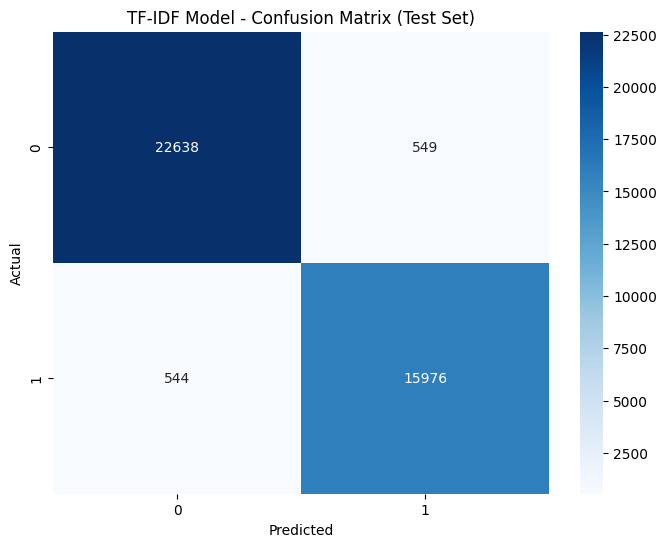

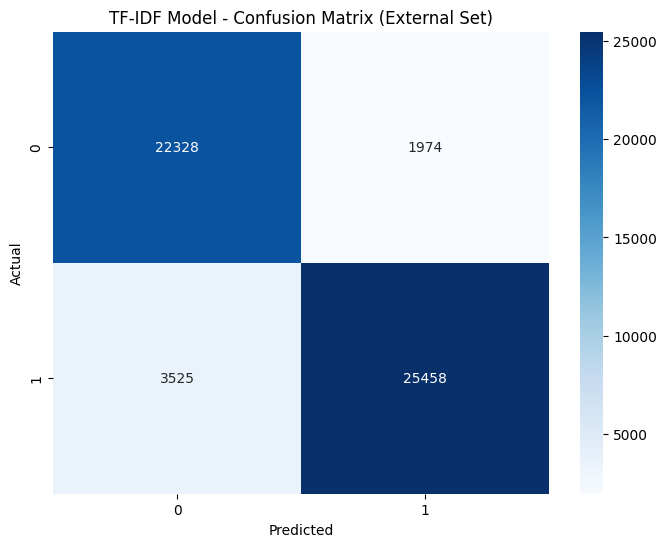

In [43]:
from scipy.sparse import hstack
tfidf = TfidfVectorizer(
    max_features=config["tfidf_max_features"],
    ngram_range=config["tfidf_ngram_range"],
    min_df=config["tfidf_min_df"],
    max_df=config["tfidf_max_df"]
)


X_tfidf_train = tfidf.fit_transform(train_df['body_subject'].to_list())
X_tfidf_test = tfidf.transform(test_df['body_subject'].to_list())
X_tfidf_external = tfidf.transform(external_df['body_subject'].to_list())

X_combined_train = hstack([X_tfidf_train, features_train])
X_combined_test = hstack([X_tfidf_test, features_test])
X_combined_external = hstack([X_tfidf_external, features_external])

print(f"Combined feature shape: {X_combined_train.shape}")
print(f"  TF-IDF features: {X_tfidf_train.shape[1]}")
print(f"  Engineered features: {features_train.shape[1]}")

lr_clf = LogisticRegression(
    max_iter=config["lr_max_iter"],
    C=config["lr_C"],
    random_state=config["random_seed"],
    verbose=1
)
lr_clf.fit(X_combined_train, y_train)

# Evaluate on test set
y_pred_test_tfidf = lr_clf.predict(X_combined_test)
y_proba_test_tfidf = lr_clf.predict_proba(X_combined_test)[:, 1]
tfidf_test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test_tfidf),
    'precision': precision_score(y_test, y_pred_test_tfidf, zero_division=0),
    'recall': recall_score(y_test, y_pred_test_tfidf, zero_division=0),
    'f1': f1_score(y_test, y_pred_test_tfidf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_test_tfidf)
}

print(f"\nTest Set Metrics:")
for metric, value in tfidf_test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Evaluate on external set
y_pred_ext_tfidf = lr_clf.predict(X_combined_external)
y_proba_ext_tfidf = lr_clf.predict_proba(X_combined_external)[:, 1]

tfidf_external_metrics = {
    'accuracy': accuracy_score(y_external, y_pred_ext_tfidf),
    'precision': precision_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'recall': recall_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'f1': f1_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'roc_auc': roc_auc_score(y_external, y_proba_ext_tfidf)
}

print(f"\nExternal Set Metrics:")
for metric, value in tfidf_external_metrics.items():
    print(f"  {metric}: {value:.4f}")

feature_names = list(tfidf.vocabulary_.keys()) + numeric_features
coefficients = lr_clf.coef_[0]
feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)

for i, (name, coef) in enumerate(feature_importance[:20], 1):
    print(f"{i:2d}. {name:<30s} {coef:+.6f}")

# Log to WandB
wandb.log({
    "tfidf/test_accuracy": tfidf_test_metrics['accuracy'],
    "tfidf/test_precision": tfidf_test_metrics['precision'],
    "tfidf/test_recall": tfidf_test_metrics['recall'],
    "tfidf/test_f1": tfidf_test_metrics['f1'],
    "tfidf/test_roc_auc": tfidf_test_metrics['roc_auc'],
    "tfidf/external_accuracy": tfidf_external_metrics['accuracy'],
    "tfidf/external_precision": tfidf_external_metrics['precision'],
    "tfidf/external_recall": tfidf_external_metrics['recall'],
    "tfidf/external_f1": tfidf_external_metrics['f1'],
    "tfidf/external_roc_auc": tfidf_external_metrics['roc_auc'],
})

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test_tfidf)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('TF-IDF Model - Confusion Matrix (Test Set)')
plt.show()
wandb.log({"tfidf/confusion_matrix": wandb.Image(fig)})
plt.close()

cm = confusion_matrix(y_external, y_pred_ext_tfidf)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('TF-IDF Model - Confusion Matrix (External Set)')
plt.show()
wandb.log({"tfidf/confusion_matrix": wandb.Image(fig)})
plt.close()


## 8. Train Hybrid XGBoost Model

Combined feature shape: (119121, 395)
  Full embeddings: 384
  Engineered features: 11

Training XGBoost...
[0]	validation_0-logloss:0.61927	validation_0-auc:0.93404	validation_1-logloss:0.62206	validation_1-auc:0.91931
[10]	validation_0-logloss:0.31492	validation_0-auc:0.98859	validation_1-logloss:0.33479	validation_1-auc:0.97967
[20]	validation_0-logloss:0.19502	validation_0-auc:0.99481	validation_1-logloss:0.22266	validation_1-auc:0.98761
[30]	validation_0-logloss:0.13508	validation_0-auc:0.99725	validation_1-logloss:0.16807	validation_1-auc:0.99093
[40]	validation_0-logloss:0.09964	validation_0-auc:0.99851	validation_1-logloss:0.13572	validation_1-auc:0.99308
[50]	validation_0-logloss:0.07762	validation_0-auc:0.99915	validation_1-logloss:0.11612	validation_1-auc:0.99428
[60]	validation_0-logloss:0.06234	validation_0-auc:0.99951	validation_1-logloss:0.10193	validation_1-auc:0.99524
[70]	validation_0-logloss:0.05179	validation_0-auc:0.99970	validation_1-logloss:0.09250	validation_1-a

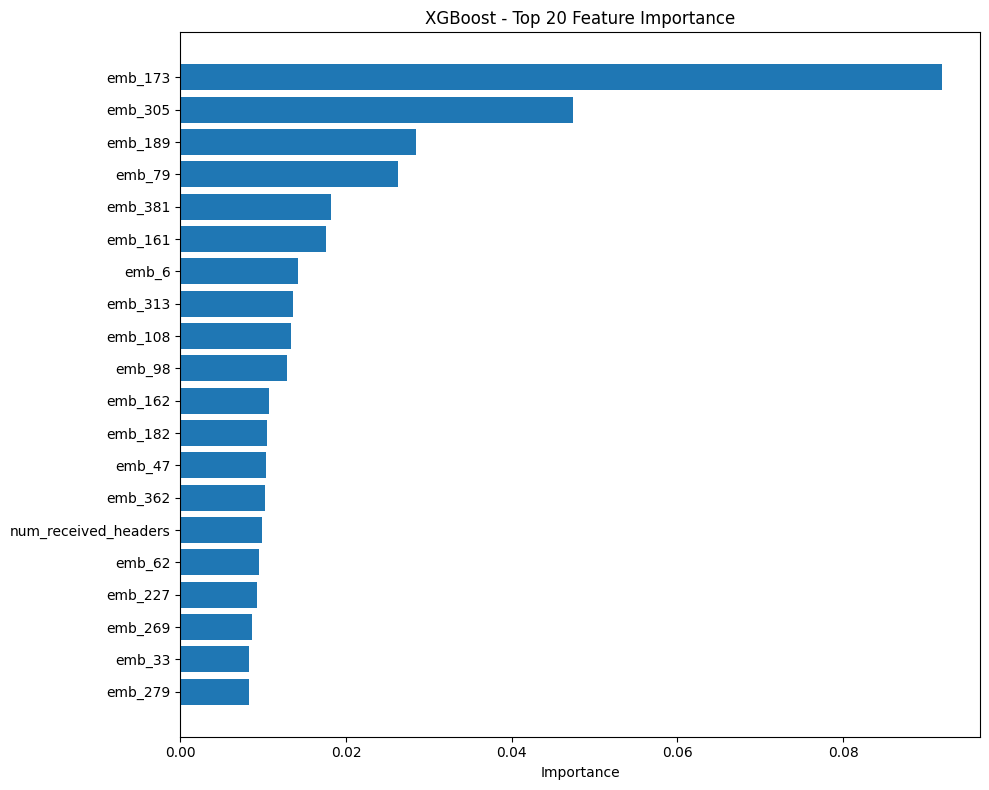

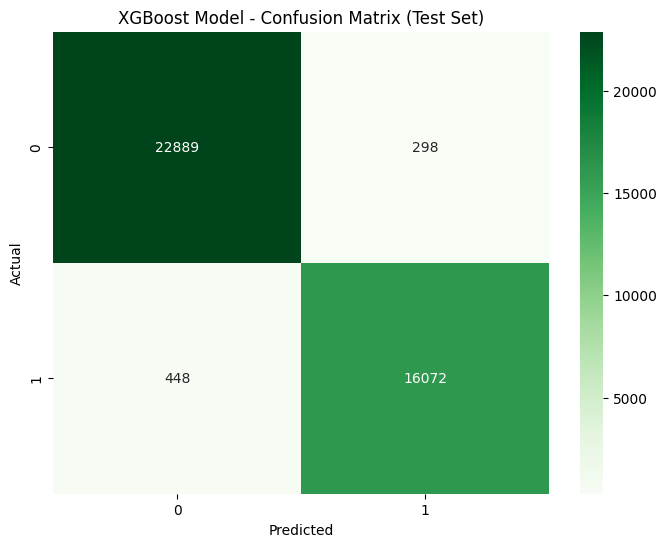

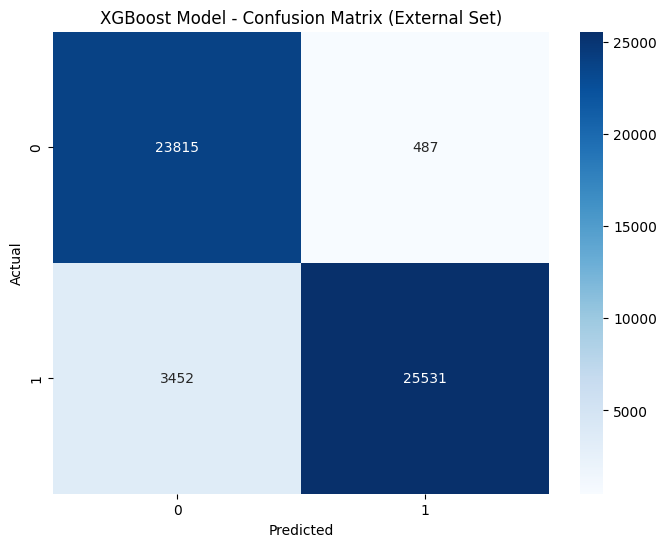

In [44]:
X_xgb_train = np.concatenate([X_emb_train, features_train], axis=1)
X_xgb_test = np.concatenate([X_emb_test, features_test], axis=1)
X_xgb_external = np.concatenate([X_emb_external, features_external], axis=1)

print(f"Combined feature shape: {X_xgb_train.shape}")
print(f"  Full embeddings: {X_emb_train.shape[1]}")
print(f"  Engineered features: {features_train.shape[1]}")

# Train XGBoost with WandB callback
xgb_clf = xgb.XGBClassifier(
    max_depth=config["xgb_max_depth"],
    n_estimators=config["xgb_n_estimators"],
    learning_rate=config["xgb_learning_rate"],
    min_child_weight=config["xgb_min_child_weight"],
    subsample=config["xgb_subsample"],
    colsample_bytree=config["xgb_colsample_bytree"],
    random_state=config["random_seed"],
    eval_metric=["logloss", "auc"],
    early_stopping_rounds=config["xgb_early_stopping"],
    callbacks=[wandb.xgboost.WandbCallback(log_model=True)]
)

print("\nTraining XGBoost...")
xgb_clf.fit(
    X_xgb_train, y_train,
    eval_set=[(X_xgb_train, y_train), (X_xgb_test, y_test)],
    verbose=10
)

# Evaluate on test set
y_pred_test_xgb = xgb_clf.predict(X_xgb_test)
y_proba_test_xgb = xgb_clf.predict_proba(X_xgb_test)[:, 1]

xgb_test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test_xgb),
    'precision': precision_score(y_test, y_pred_test_xgb, zero_division=0),
    'recall': recall_score(y_test, y_pred_test_xgb, zero_division=0),
    'f1': f1_score(y_test, y_pred_test_xgb, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_test_xgb)
}

print(f"\nTest Set Metrics:")
for metric, value in xgb_test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Evaluate on external set
y_pred_ext_xgb = xgb_clf.predict(X_xgb_external)
y_proba_ext_xgb = xgb_clf.predict_proba(X_xgb_external)[:, 1]

xgb_external_metrics = {
    'accuracy': accuracy_score(y_external, y_pred_ext_xgb),
    'precision': precision_score(y_external, y_pred_ext_xgb, zero_division=0),
    'recall': recall_score(y_external, y_pred_ext_xgb, zero_division=0),
    'f1': f1_score(y_external, y_pred_ext_xgb, zero_division=0),
    'roc_auc': roc_auc_score(y_external, y_proba_ext_xgb)
}

print(f"\nExternal Set Metrics:")
for metric, value in xgb_external_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Log to WandB
wandb.log({
    "xgboost/test_accuracy": xgb_test_metrics['accuracy'],
    "xgboost/test_precision": xgb_test_metrics['precision'],
    "xgboost/test_recall": xgb_test_metrics['recall'],
    "xgboost/test_f1": xgb_test_metrics['f1'],
    "xgboost/test_roc_auc": xgb_test_metrics['roc_auc'],
    "xgboost/external_accuracy": xgb_external_metrics['accuracy'],
    "xgboost/external_precision": xgb_external_metrics['precision'],
    "xgboost/external_recall": xgb_external_metrics['recall'],
    "xgboost/external_f1": xgb_external_metrics['f1'],
    "xgboost/external_roc_auc": xgb_external_metrics['roc_auc'],
})

feature_names = [f"emb_{i}" for i in range(X_emb_train.shape[1])] + numeric_features
importance = xgb_clf.feature_importances_
feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

print("\nTop 20 Important Features:")
for i, (name, imp) in enumerate(feature_importance[:20], 1):
    print(f"{i:2d}. {name:<30s} {imp:.6f}")

fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance[:20]
ax.barh([f[0] for f in top_features][::-1], [f[1] for f in top_features][::-1])
ax.set_xlabel('Importance')
ax.set_title('XGBoost - Top 20 Feature Importance')
plt.tight_layout()
wandb.log({"xgboost/feature_importance": wandb.Image(fig)})
plt.show()
plt.close()

# Confusion matrix for XGBoost
cm = confusion_matrix(y_test, y_pred_test_xgb)
fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax_cm)
ax_cm.set_xlabel('Predicted')
ax_cm.set_ylabel('Actual')
ax_cm.set_title('XGBoost Model - Confusion Matrix (Test Set)')
wandb.log({"xgboost/confusion_matrix": wandb.Image(fig_cm)})
plt.show()
plt.close()

cm = confusion_matrix(y_external, y_pred_ext_xgb)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('XGBoost Model - Confusion Matrix (External Set)')
plt.show()
wandb.log({"xgboost/confusion_matrix": wandb.Image(fig)})
plt.close()


## 9. Train Hybrid MLP Model

In [45]:
from hybrid_mlp_model import HybridMLPClassifier

X_emb_train_fit, X_emb_val, X_feat_train_fit, X_feat_val, y_train_fit, y_val = train_test_split(
    X_emb_train, features_train, y_train, 
    test_size=0.2, 
    random_state=config["random_seed"], 
    stratify=y_train
)

print(f"Train: {X_emb_train_fit.shape[0]} | Val: {X_emb_val.shape[0]} | Test: {X_emb_test.shape[0]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = HybridMLPClassifier(
    embedding_dim=config["embedding_dim"],
    num_features=len(numeric_features),
    feature_hidden_dim=config["mlp_feature_hidden_dim"],
    dropout=config["mlp_dropout"]
).to(device)

print(mlp_model)
print(f"\nTotal parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")

# Create data loaders
train_dataset = TensorDataset(
    torch.FloatTensor(X_emb_train_fit),
    torch.FloatTensor(X_feat_train_fit),
    torch.FloatTensor(y_train_fit)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_emb_val),
    torch.FloatTensor(X_feat_val),
    torch.FloatTensor(y_val)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_emb_test),
    torch.FloatTensor(features_test),
    torch.FloatTensor(y_test)
)

train_loader = DataLoader(train_dataset, batch_size=config["mlp_batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["mlp_batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

# Training setup
optimizer = torch.optim.Adam(
    mlp_model.parameters(), 
    lr=config["mlp_lr"], 
    weight_decay=config["mlp_weight_decay"]
)
criterion = nn.BCEWithLogitsLoss()

# Training loop
best_val_loss = float('inf')
patience_counter = 0

print("\nTraining MLP...")
for epoch in range(config["mlp_epochs"]):
    # Training
    mlp_model.train()
    train_loss = 0
    for embeddings, features, labels in train_loader:
        embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = mlp_model(embeddings, features).squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    mlp_model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for embeddings, features, labels in val_loader:
            embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
            
            logits = mlp_model(embeddings, features).squeeze()
            loss = criterion(logits, labels)
            val_loss += loss.item()
            
            probs = torch.sigmoid(logits)
            val_preds.extend(probs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    val_pred_binary = (val_preds > 0.5).astype(int)
    
    val_acc = accuracy_score(val_labels, val_pred_binary)
    val_f1 = f1_score(val_labels, val_pred_binary, zero_division=0)
    
    # Log to WandB
    wandb.log({
        "mlp/epoch": epoch,
        "mlp/train_loss": train_loss,
        "mlp/val_loss": val_loss,
        "mlp/val_accuracy": val_acc,
        "mlp/val_f1": val_f1
    })
    
    print(f"Epoch {epoch+1}/{config['mlp_epochs']}: "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        best_model_state = mlp_model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= config["mlp_early_stopping"]:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
mlp_model.load_state_dict(best_model_state)

Train: 95296 | Val: 23825 | Test: 39707
HybridMLPClassifier(
  (feature_branch): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=416, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Total parameters: 140,161

Training MLP...
Epoch 1/50: Train Loss: 0.1448 | Val Loss: 0.0852 | Val Acc: 0.9697 | Val F1: 0.9635
Epoch 2/50: Train Loss: 0.0808 | Val Loss: 0.0678 | Val Acc: 0.9762 | Val F1: 0.9716
Epoch 3/50: Train Loss: 0.0650 | Val Loss: 0.0599 | Val Acc: 0.9788 | Val F1: 0.9745
Epoch 4/50: Train Loss: 0.0550 | Val Loss: 0.0589 | Val Acc: 0.9793 | Val F1: 0.9753
Epoch 5/50: Train Loss: 0.0491 | Val Loss: 0.0583 | Val Acc: 0.9790 | Val F1

<All keys matched successfully>


MLP Test Set Metrics:
  accuracy: 0.9817
  precision: 0.9711
  recall: 0.9852
  f1: 0.9781
  roc_auc: 0.9980

MLP External Set Metrics:
  accuracy: 0.9307
  precision: 0.9594
  recall: 0.9113
  f1: 0.9347
  roc_auc: 0.9797


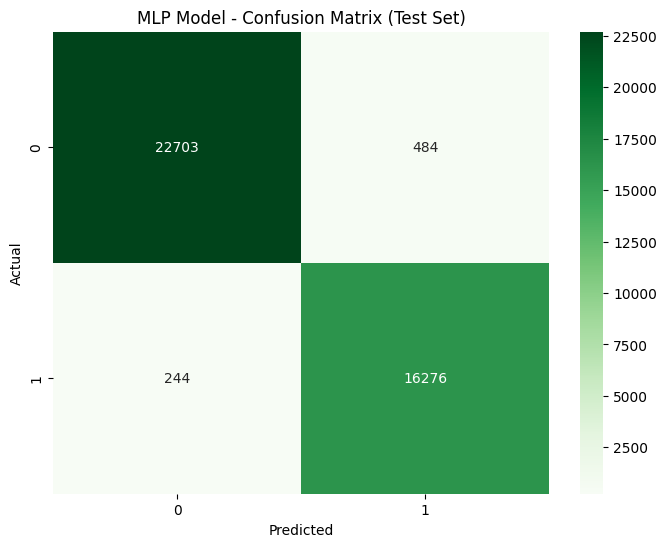

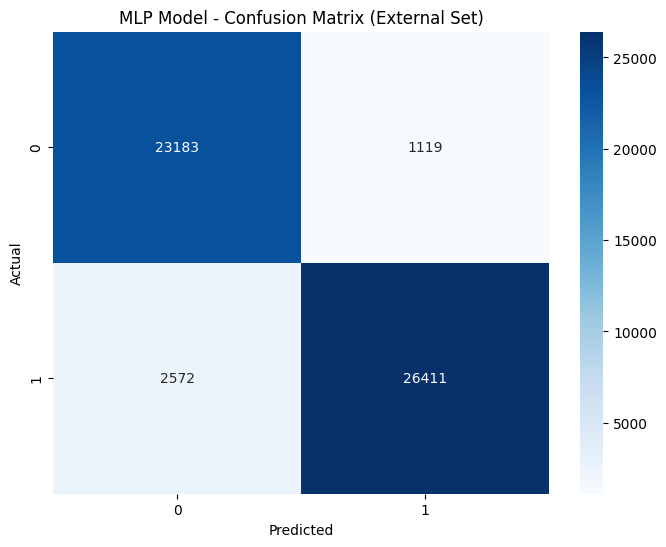

In [46]:
# Evaluate MLP on test set
mlp_model.eval()
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for embeddings, features, labels in test_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        # Handle both batch and single samples
        if probs.dim() == 0:
            test_probs.append(probs.cpu().item())
            test_labels.append(labels.item())
        else:
            test_probs.extend(probs.cpu().numpy())
            test_labels.extend(labels.numpy())

test_probs = np.array(test_probs)
test_labels = np.array(test_labels)
test_preds = (test_probs > 0.5).astype(int)

mlp_test_metrics = {
    'accuracy': accuracy_score(test_labels, test_preds),
    'precision': precision_score(test_labels, test_preds, zero_division=0),
    'recall': recall_score(test_labels, test_preds, zero_division=0),
    'f1': f1_score(test_labels, test_preds, zero_division=0),
    'roc_auc': roc_auc_score(test_labels, test_probs)
}

print(f"\nMLP Test Set Metrics:")
for metric, value in mlp_test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Evaluate on external set
external_dataset = TensorDataset(
    torch.FloatTensor(X_emb_external),
    torch.FloatTensor(features_external),
    torch.FloatTensor(y_external)
)
external_loader = DataLoader(external_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

ext_preds = []
ext_labels = []
ext_probs = []

with torch.no_grad():
    for embeddings, features, labels in external_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        # Handle both batch and single samples
        if probs.dim() == 0:
            ext_probs.append(probs.cpu().item())
            ext_labels.append(labels.item())
        else:
            ext_probs.extend(probs.cpu().numpy())
            ext_labels.extend(labels.numpy())

ext_probs = np.array(ext_probs)
ext_labels = np.array(ext_labels)
ext_preds = (ext_probs > 0.5).astype(int)

mlp_external_metrics = {
    'accuracy': accuracy_score(ext_labels, ext_preds),
    'precision': precision_score(ext_labels, ext_preds, zero_division=0),
    'recall': recall_score(ext_labels, ext_preds, zero_division=0),
    'f1': f1_score(ext_labels, ext_preds, zero_division=0),
    'roc_auc': roc_auc_score(ext_labels, ext_probs)
}

print(f"\nMLP External Set Metrics:")
for metric, value in mlp_external_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Log to WandB
wandb.log({
    "mlp/test_accuracy": mlp_test_metrics['accuracy'],
    "mlp/test_precision": mlp_test_metrics['precision'],
    "mlp/test_recall": mlp_test_metrics['recall'],
    "mlp/test_f1": mlp_test_metrics['f1'],
    "mlp/test_roc_auc": mlp_test_metrics['roc_auc'],
    "mlp/external_accuracy": mlp_external_metrics['accuracy'],
    "mlp/external_precision": mlp_external_metrics['precision'],
    "mlp/external_recall": mlp_external_metrics['recall'],
    "mlp/external_f1": mlp_external_metrics['f1'],
    "mlp/external_roc_auc": mlp_external_metrics['roc_auc'],
})

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('MLP Model - Confusion Matrix (Test Set)')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()

cm = confusion_matrix(ext_labels, ext_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('MLP Model - Confusion Matrix (External Set)')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()
plt.close()

## 10. Compare Model Performance

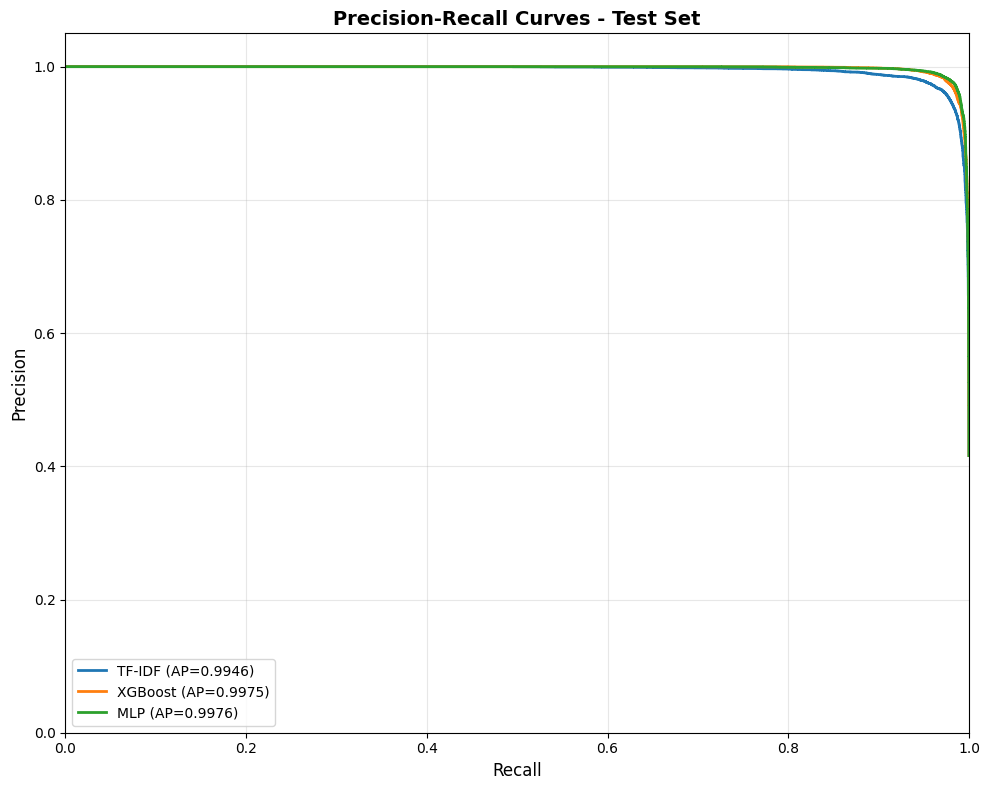

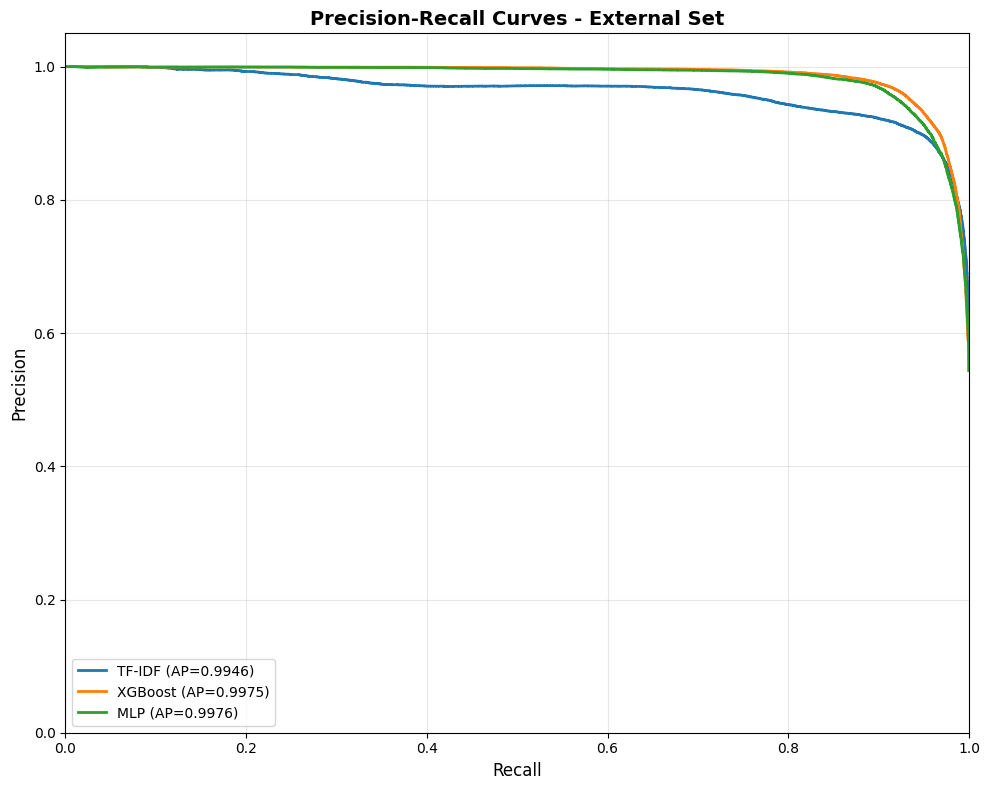


TEST SET PERFORMANCE:
Model                Accuracy     Precision    Recall       F1           ROC-AUC     
--------------------------------------------------------------------------------
TF-IDF + LogReg      0.9725       0.9668       0.9671       0.9669       0.9959      
XGBoost Hybrid       0.9812       0.9818       0.9729       0.9773       0.9980      
MLP Hybrid           0.9817       0.9711       0.9852       0.9781       0.9980      

EXTERNAL VALIDATION SET PERFORMANCE:
Model                Accuracy     Precision    Recall       F1           ROC-AUC     
--------------------------------------------------------------------------------
TF-IDF + LogReg      0.8968       0.9280       0.8784       0.9025       0.9632      
XGBoost Hybrid       0.9261       0.9813       0.8809       0.9284       0.9827      
MLP Hybrid           0.9307       0.9594       0.9113       0.9347       0.9797      


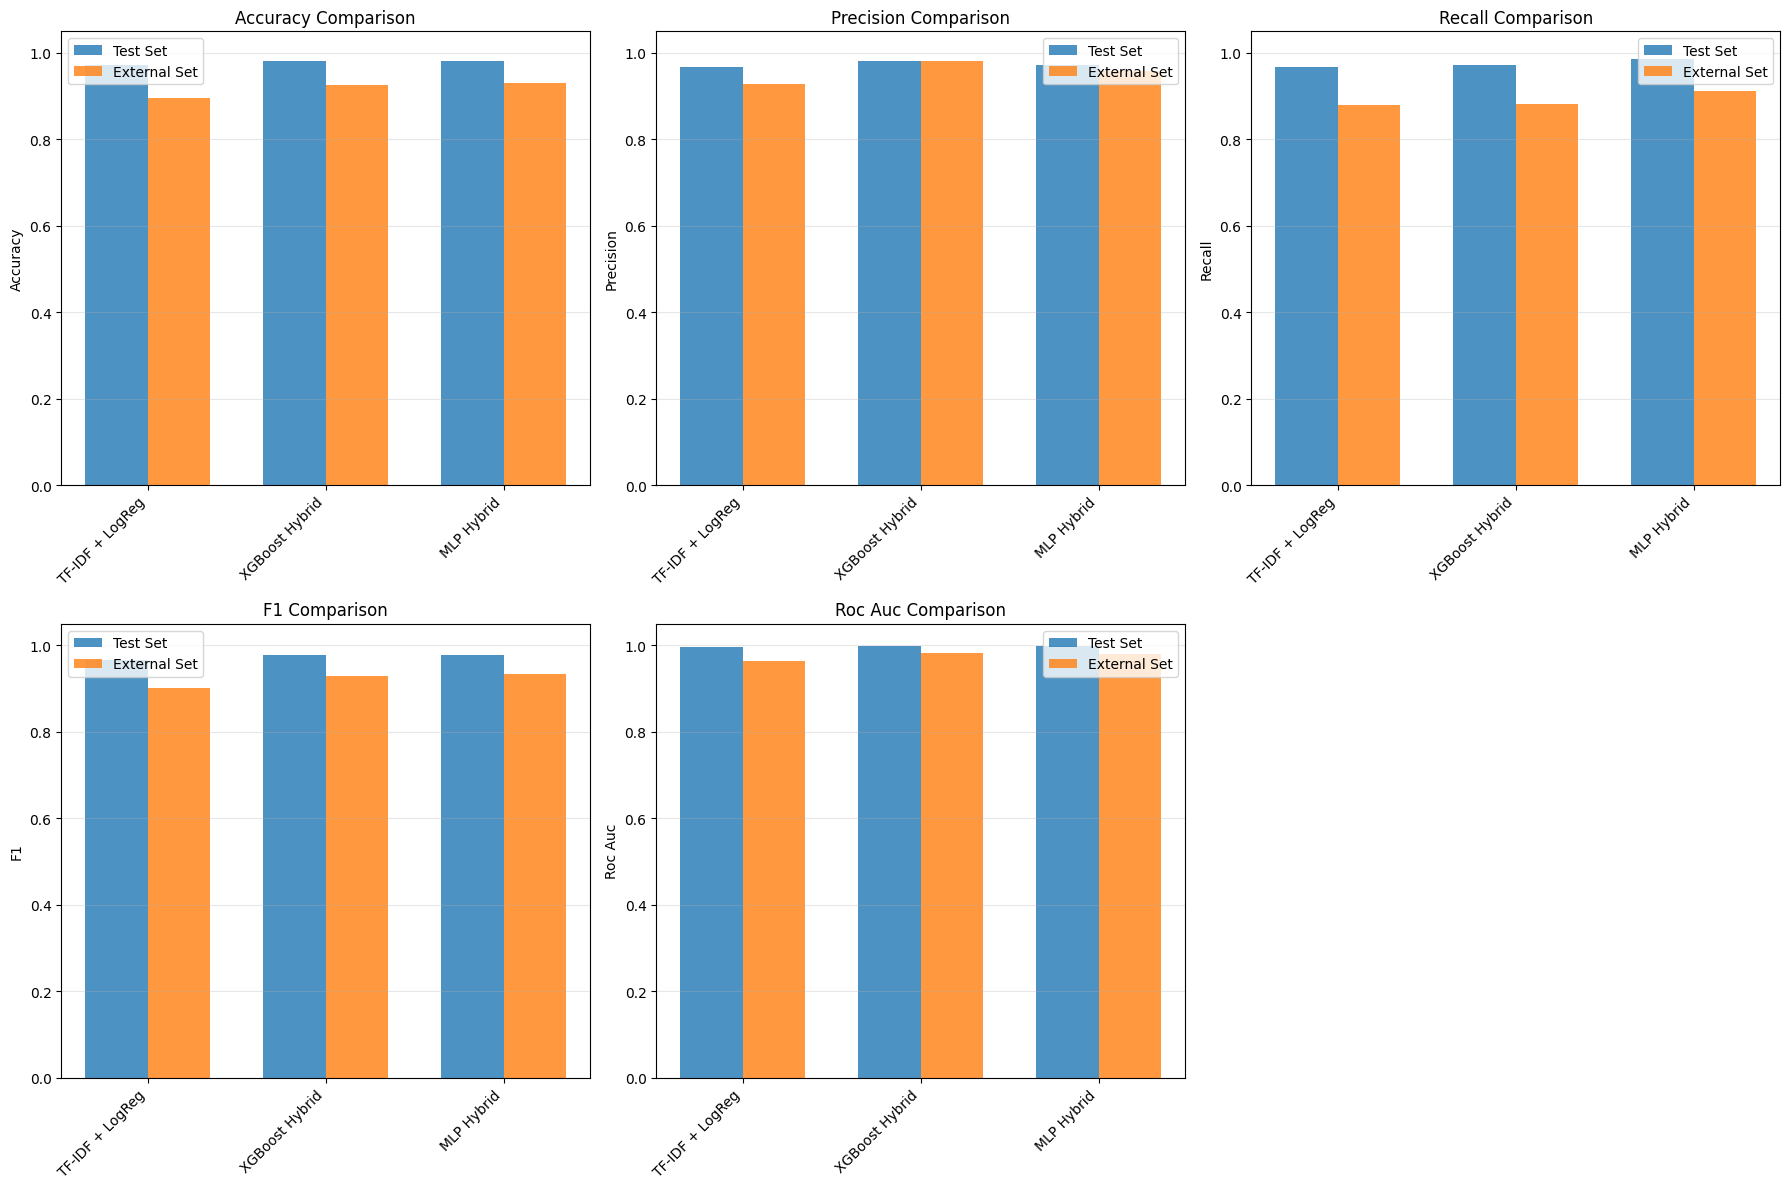

In [47]:
# Create comprehensive comparison
comparison_data = {
    'TF-IDF + LogReg': {
        'test': tfidf_test_metrics,
        'external': tfidf_external_metrics
    },
    'XGBoost Hybrid': {
        'test': xgb_test_metrics,
        'external': xgb_external_metrics
    },
    'MLP Hybrid': {
        'test': mlp_test_metrics,
        'external': mlp_external_metrics
    }
}

from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate PR curves
tfidf_precision_test, tfidf_recall_test, _ = precision_recall_curve(y_test, y_proba_test_tfidf)
xgb_precision_test, xgb_recall_test, _ = precision_recall_curve(y_test, y_proba_test_xgb)
mlp_precision_test, mlp_recall_test, _ = precision_recall_curve(test_labels, test_probs)

tfidf_precision_ex, tfidf_recall_ex, _ = precision_recall_curve(y_external, y_proba_ext_tfidf)
xgb_precision_ex, xgb_recall_ex, _ = precision_recall_curve(y_external, y_proba_ext_xgb)
mlp_precision_ex, mlp_recall_ex, _ = precision_recall_curve(ext_labels, ext_probs)


# Calculate average precision
tfidf_ap = average_precision_score(y_test, y_proba_test_tfidf)
xgb_ap = average_precision_score(y_test, y_proba_test_xgb)
mlp_ap = average_precision_score(test_labels, test_probs)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tfidf_recall_test, tfidf_precision_test, label=f'TF-IDF (AP={tfidf_ap:.4f})', linewidth=2)
ax.plot(xgb_recall_test, xgb_precision_test, label=f'XGBoost (AP={xgb_ap:.4f})', linewidth=2)
ax.plot(mlp_recall_test, mlp_precision_test, label=f'MLP (AP={mlp_ap:.4f})', linewidth=2)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - Test Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
wandb.log({"comparison/pr_curves": wandb.Image(fig)})
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tfidf_recall_ex, tfidf_precision_ex, label=f'TF-IDF (AP={tfidf_ap:.4f})', linewidth=2)
ax.plot(xgb_recall_ex, xgb_precision_ex, label=f'XGBoost (AP={xgb_ap:.4f})', linewidth=2)
ax.plot(mlp_recall_ex, mlp_precision_ex, label=f'MLP (AP={mlp_ap:.4f})', linewidth=2)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - External Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
wandb.log({"comparison/pr_curves": wandb.Image(fig)})
plt.show()
plt.close()

# Test set comparison
print("\nTEST SET PERFORMANCE:")
print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'ROC-AUC':<12}")
print("-" * 80)
for model_name, metrics in comparison_data.items():
    test_m = metrics['test']
    print(f"{model_name:<20} {test_m['accuracy']:<12.4f} {test_m['precision']:<12.4f} "
          f"{test_m['recall']:<12.4f} {test_m['f1']:<12.4f} {test_m['roc_auc']:<12.4f}")

# External set comparison
print("\nEXTERNAL VALIDATION SET PERFORMANCE:")
print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'ROC-AUC':<12}")
print("-" * 80)
for model_name, metrics in comparison_data.items():
    ext_m = metrics['external']
    print(f"{model_name:<20} {ext_m['accuracy']:<12.4f} {ext_m['precision']:<12.4f} "
          f"{ext_m['recall']:<12.4f} {ext_m['f1']:<12.4f} {ext_m['roc_auc']:<12.4f}")

# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    models = list(comparison_data.keys())
    test_values = [comparison_data[m]['test'][metric] for m in models]
    external_values = [comparison_data[m]['external'][metric] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    ax.bar(x - width/2, test_values, width, label='Test Set', alpha=0.8)
    ax.bar(x + width/2, external_values, width, label='External Set', alpha=0.8)
    
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
wandb.log({"comparison/metrics_comparison": wandb.Image(fig)})
plt.show()

comparison_table_data = []
for model_name, metrics in comparison_data.items():
    for split, split_metrics in metrics.items():
        row = [model_name, split] + [split_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
        comparison_table_data.append(row)

comparison_table = wandb.Table(
    columns=['Model', 'Split', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'],
    data=comparison_table_data
)
wandb.log({"comparison/performance_table": comparison_table})


## 11. Save Models and Artifacts


In [ ]:
# Create directories
os.makedirs("../../output/saved_models", exist_ok=True)
os.makedirs("../../output/saved_artifacts", exist_ok=True)

print("Saving models and artifacts...")

with open('../../output/saved_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('../../output/saved_models/tfidf_classifier.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)

xgb_clf.save_model('../../output/saved_models/xgboost_hybrid.json')

torch.save({
    'model_state_dict': mlp_model.state_dict(),
    'embedding_dim': config["embedding_dim"],
    'num_features': len(numeric_features),
    'feature_hidden_dim': config["mlp_feature_hidden_dim"],
    'dropout': config["mlp_dropout"],
    'test_metrics': mlp_test_metrics,
    'external_metrics': mlp_external_metrics
}, '../../output/saved_models/mlp_hybrid.pth')
# Save experiment configuration (no SVD)
full_config = {
    'experiment_config': config,
    'data_splits': {
        'train_size': len(train_df),
        'test_size': len(test_df),
        'external_size': len(external_df)
    },
    'model_performance': {
        'tfidf': {
            'test': {k: float(v) for k, v in tfidf_test_metrics.items()},
            'external': {k: float(v) for k, v in tfidf_external_metrics.items()}
        },
        'xgboost': {
            'test': {k: float(v) for k, v in xgb_test_metrics.items()},
            'external': {k: float(v) for k, v in xgb_external_metrics.items()}
        },
        'mlp': {
            'test': {k: float(v) for k, v in mlp_test_metrics.items()},
            'external': {k: float(v) for k, v in mlp_external_metrics.items()}
        }
    },
    'feature_names': numeric_features,
    'timestamp': datetime.now().isoformat()
}

with open('../../output/saved_artifacts/experiment_config.json', 'w') as f:
    json.dump(full_config, f, indent=2)

# Upload artifacts to WandB
artifact = wandb.Artifact('phishstop-models', type='model')
artifact.add_dir('../../output/saved_models')
artifact.add_file('../../output/saved_artifacts/experiment_config.json')
wandb.log_artifact(artifact)



wandb: Adding directory to artifact (..\..\output\saved_models)... Done. 0.0s


Saving models and artifacts...


Error: You must call wandb.init() before wandb.log_artifact()

In [49]:
# Finish WandB run
wandb.finish()
print("✓ WandB run completed")

best_iteration,▁
best_score,▁
class_balance,▁
embedding_dim,▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
external_phishing_ratio,▁
external_size,▁
legit_count,▁
mlp/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
mlp/external_accuracy,▁
+43,...


✓ WandB run completed
